# setup

In [229]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [230]:
pq_path = "../data/flightdata/flights_2022.parquet"
csv_path = "../data/flightdata/flights_2022.csv"

In [231]:
df = pd.read_csv(csv_path)

# eda

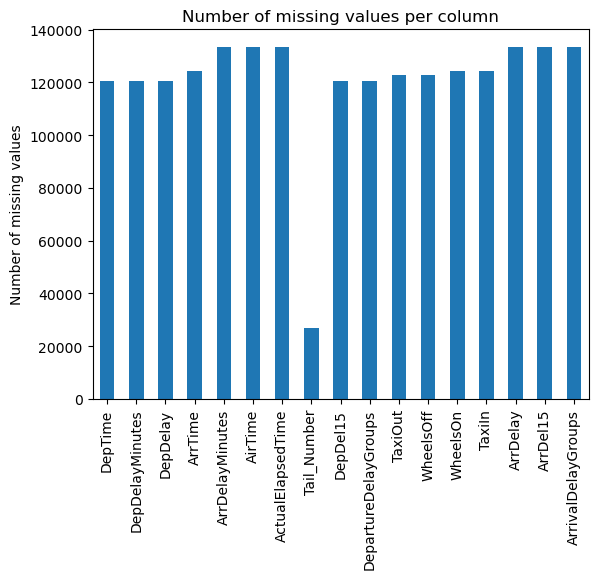

In [5]:
# Generate a bar chart for number of missing values per column in the dataset
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values.plot(kind="bar")
plt.title("Number of missing values per column")
plt.ylabel("Number of missing values")
plt.show()

In [232]:
# Drop rows with missing values
df = df.dropna()

In [233]:
# Get the columns that have missing values
missing_columns = missing_values.index
print(missing_columns)
print(range(len(missing_columns)))

missing_cols_idx_to_keep = [0, 2, 3, 4, 8, 14, 15, 16]

missing_cols_to_remove = [missing_columns[i] for i in range(len(missing_columns)) if i not in missing_cols_idx_to_keep]
print(missing_cols_to_remove)

Index(['DepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime', 'ArrDelayMinutes',
       'AirTime', 'ActualElapsedTime', 'Tail_Number', 'DepDel15',
       'DepartureDelayGroups', 'TaxiOut', 'WheelsOff', 'WheelsOn', 'TaxiIn',
       'ArrDelay', 'ArrDel15', 'ArrivalDelayGroups'],
      dtype='object')
range(0, 17)
['DepDelayMinutes', 'AirTime', 'ActualElapsedTime', 'Tail_Number', 'DepartureDelayGroups', 'TaxiOut', 'WheelsOff', 'WheelsOn', 'TaxiIn']


In [234]:
missing_cols_to_keep = [missing_columns[i] for i in range(len(missing_columns)) if i in missing_cols_idx_to_keep]
print(missing_cols_to_keep)

['DepTime', 'DepDelay', 'ArrTime', 'ArrDelayMinutes', 'DepDel15', 'ArrDelay', 'ArrDel15', 'ArrivalDelayGroups']


# notes

CRSDepTime - scheduled departure time (local, hhmm)

departureDelayMinutes - departure delay (in minutes) <- remove this one

departureDelay - departure delay (in minutes) but early departures are negative

In [235]:
cols_to_drop = [
    "Operated_or_Branded_Code_Share_Partners",
    "DOT_ID_Marketing_Airline",
    "DOT_ID_Operating_Airline",
    "IATA_Code_Marketing_Airline",
    "IATA_Code_Operating_Airline",
    "OriginAirportSeqID",
    "OriginCityMarketID",
    "DestAirportSeqID",
    "DestCityMarketID",
    "DepTimeBlk",
    "ArrDelayMinutes",
    "ArrivalDelayGroups",
    "ArrTimeBlk",
    "DistanceGroup",
    "DivAirportLandings",
    "DepDelayMinutes",
    "AirTime",
    "ActualElapsedTime",
    "Tail_Number",
    "DepartureDelayGroups",
    "OriginAirportID",
    "OriginCityName",
    "OriginState",
    "OriginStateFips",
    "OriginStateName",
    "OriginWac",
    "DestAirportID",
    "DestCityName",
    "DestState",
    "DestStateFips",
    "DestStateName",
    "DestWac",
    "Year",
    "Month",
    "DayofMonth",
    "Quarter",
    "Cancelled",
    "Diverted",
]

new_cols = [
    "flightDate",
    "fullAirlineName",
    "originCode",
    "destinationCode",
    "scheduledDepartureTime",
    "actualDepartureTime",
    "departureDelayMinutes",
    "actualArrivalTime",
    "scheduledAirTime",
    "distanceMiles",
    "dayOfWeek",
    "marketingAirlineNetwork",
    "flightNumberMarketingAirline",
    "operatingAirlineCode",
    "flightNumberOperatingAirline",
    "departureDelayBool",
    "taxiOut",
    "wheelsOff",
    "wheelsOn",
    "taxiIn",
    "scheduledArrivalTime",
    "arrivalDelayMinutes",
    "arrivalDelayBool",
]

In [236]:
dropped_df = df.drop(cols_to_drop, axis=1, inplace=False)
dropped_df.columns = new_cols
dropped_df.sample().head(1)

,flightDate,fullAirlineName,originCode,destinationCode,scheduledDepartureTime,actualDepartureTime,departureDelayMinutes,actualArrivalTime,scheduledAirTime,distanceMiles,...,operatingAirlineCode,flightNumberOperatingAirline,departureDelayBool,taxiOut,wheelsOff,wheelsOn,taxiIn,scheduledArrivalTime,arrivalDelayMinutes,arrivalDelayBool
1138202,2022-07-07,SkyWest Airlines Inc.,DEN,ASE,2021,2021.0,0.0,2102.0,55.0,125.0,...,OO,5729,0.0,10.0,2031.0,2058.0,4.0,2116,-14.0,0.0


In [237]:
def convert_float_time(row) -> dt.datetime:
    """Converts a float time to a datetime object"""
    # convert flightDate value to string it is in format YYYYMMDD
    flight_date = str(row["flightDate"])

    to_dt_columns = [
        "scheduledDepartureTime",
        "actualDepartureTime",
        "scheduledArrivalTime",
        "actualArrivalTime",
        "wheelsOff",
        "wheelsOn",
    ]

    for column in to_dt_columns:
        # if the value is a datetime object, skip it
        if isinstance(row[column], dt.datetime):
            continue

        time = str(int(row[column])).zfill(4)
        hour = time[:2]
        minute = time[2:]

        if hour == "24":
            hour = "00"

        row[column] = dt.datetime.strptime(
            f"{flight_date} {hour}:{minute}", "%Y-%m-%d %H:%M"
        )

    return row

In [240]:
# Convert scheduledDepartureTime, actualDepartureTime, scheduledArrivalTime, actualArrivalTime to datetime they are floats in format HHMM in 24hour time
sample_df = dropped_df.sample(frac=0.1, random_state=42).head(1)
sample_df = sample_df.apply(convert_float_time, axis=1)

# Drop rows with missing values again
cleaned_full_data = sample_df.dropna()

cleaned_full_data[["flightDate", "scheduledArrivalTime"]].sample().head(1)

,flightDate,scheduledArrivalTime
1054765,2022-02-23,2022-02-23 10:14:00


Text(0, 0.5, 'Frequency')

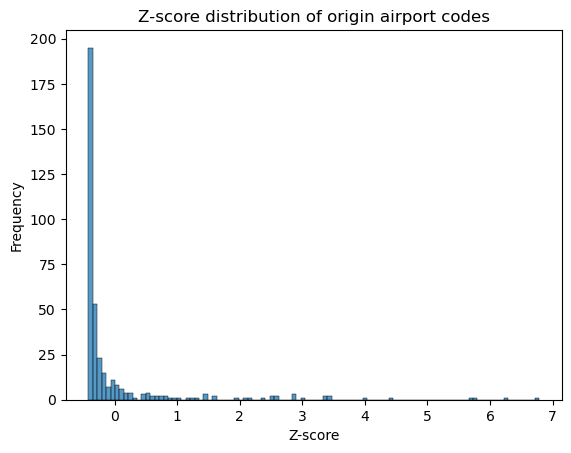

In [93]:
# Based on originCode and destinationCode calculate the standard deviation of the value_counts distribution
origin_code_std = dropped_df["originCode"].value_counts().std()
destination_code_std = dropped_df["destinationCode"].value_counts().std()

# Measure the average now
origin_code_avg = dropped_df["originCode"].value_counts().mean()
destination_code_avg = dropped_df["destinationCode"].value_counts().mean()

# Calculate the zscores
origin_code_zscore = (dropped_df["originCode"].value_counts() - origin_code_avg) / origin_code_std
destination_code_zscore = (dropped_df["destinationCode"].value_counts() - destination_code_avg) / destination_code_std

# Show zscore distribution
sns.histplot(origin_code_zscore)

# Add title/axes
plt.title("Z-score distribution of origin airport codes")
plt.xlabel("Z-score")
plt.ylabel("Frequency")

In [90]:
origin_code_zscore = origin_code_zscore.reset_index()
origin_code_zscore.head()

,index,originCode,count
0,0,ATL,6.788686
1,1,ORD,6.241004
2,2,DFW,5.797478
3,3,DEN,5.723510
4,4,CLT,4.451265


In [101]:
origin_vc = dropped_df.originCode.value_counts()

# convert origin_vc to dataframe
origin_vc = origin_vc.reset_index()

# combine origin_vc with zscores
origin_vc["zscores"] = origin_code_zscore.values

# in origin_vc keep rows where zscore is greater than 0
origin_vc = origin_vc[origin_vc["zscores"] > 0]

In [102]:
dest_vc = dropped_df.destinationCode.value_counts()

# convert dest_vc to dataframe
dest_vc = dest_vc.reset_index()

# combine dest_vc with zscores
dest_vc["zscores"] = destination_code_zscore.values

# in dest_vc keep rows where zscore is greater than 0
dest_vc = dest_vc[dest_vc["zscores"] > 0]

In [59]:
# save origin_vc as csv
origin_vc.to_csv("../data/origin_vc.csv", index=False)

In [113]:
def cull_airport_codes(df: pd.DataFrame, thresh: int = 1):
    kept_airport_codes = []

    code_cols = ["originCode", "destinationCode"]

    for col in code_cols:
        std = df[col].value_counts().std()
        avg = df[col].value_counts().mean()
        zscores = (df[col].value_counts() - avg) / std

        col_series = df[col].value_counts()
        col_series = col_series.reset_index()
        col_series["zscore"] = zscores.values

        # Keep codes with zscore greater than 0
        keep_codes = col_series[col_series["zscore"] > thresh][col].to_list()

        kept_airport_codes.extend(keep_codes)

    # Keep unique codes
    kept_airport_codes = list(set(kept_airport_codes))

    # If the code of either the origin or destination is not
    # in the kept_airport_codes list, drop the row
    df = df[
        df["originCode"].isin(kept_airport_codes)
        & df["destinationCode"].isin(kept_airport_codes)
    ]

    return df

In [115]:
culled_df = cull_airport_codes(dropped_df)

In [126]:
def cull_airlines(df: pd.DataFrame):
    """Remove airlines with fewer than 20000 flights."""
    airline_counts = df["fullAirlineName"].value_counts()
    airline_counts = airline_counts[airline_counts > 20000]

    df = df[df["fullAirlineName"].isin(airline_counts.index)]

    return df

culled_df = cull_airlines(culled_df)

In [161]:
def combine_airline_code_flight_number(df: pd.DataFrame):
    """Combine airline code and flight number into one column."""
    code = df["operatingAirlineCode"]
    number = df["flightNumberOperatingAirline"]

    df["flightNumber"] = code + number.astype(str)

    # Drop the original columns
    cols_to_drop = [
        "marketingAirlineNetwork",
        "flightNumberOperatingAirline",
        "flightNumberMarketingAirline",
        "fullAirlineName",
    ]

    # We keep operatingAirlineCode for encoding

    df = df.drop(
        columns=cols_to_drop,
    )
    return df

In [160]:
def calculate_operating_airline_reliability_score(df: pd.DataFrame):
    """Calculate a reliability score for each airline."""
    reliability_score = (
        df.groupby("operatingAirlineCode")[
            ["arrivalDelayMinutes", "departureDelayMinutes"]
        ]
        .mean()
        .sum(axis=1)
        / 2
    )

    # Create a dictionary to map the operatingAirlineCode to the score
    reliability_score_dict = reliability_score.to_dict()

    # Map the operatingAirlineCode to the reliability score
    df["reliabilityScore"] = df["operatingAirlineCode"].map(
        reliability_score_dict
    )

    # Drop the operatingAirlineCode column
    df = df.drop(columns=["operatingAirlineCode"])

    return df

In [162]:
pre_weather_df = combine_airline_code_flight_number(culled_df)
pre_weather_df = calculate_operating_airline_reliability_score(pre_weather_df)
pre_weather_df.head(3)

,flightDate,originCode,destinationCode,scheduledDepartureTime,actualDepartureTime,departureDelayMinutes,actualArrivalTime,scheduledAirTime,distanceMiles,dayOfWeek,departureDelayBool,taxiOut,wheelsOff,wheelsOn,taxiIn,scheduledArrivalTime,arrivalDelayMinutes,arrivalDelayBool,flightNumber,reliabilityScore
1855,2022-04-01,ATL,AUS,820,832.0,12.0,1004.0,160.0,813.0,5,0.0,13.0,845.0,1000.0,4.0,1000,4.0,0.0,WN649,13.128708
1856,2022-04-01,ATL,AUS,1440,1505.0,25.0,1632.0,155.0,813.0,5,1.0,11.0,1516.0,1625.0,7.0,1615,17.0,1.0,WN1057,13.128708
1857,2022-04-01,ATL,AUS,1955,2105.0,70.0,2237.0,160.0,813.0,5,1.0,18.0,2123.0,2232.0,5.0,2135,62.0,1.0,WN1765,13.128708


# weather

In [123]:
# load in iata/icao data
airport_location_df = pd.read_csv("../data/iata-icao.csv")
airport_location_df.head(3)

,country_code,region_name,iata,icao,airport,latitude,longitude
0,AE,Abu Zaby,AAN,OMAL,Al Ain International Airport,24.2617,55.6092
1,AE,Abu Zaby,AUH,OMAA,Abu Dhabi International Airport,24.4330,54.6511
2,AE,Abu Zaby,AYM,NaN,Yas Island Seaplane Base,24.4670,54.6103


In [125]:
# clean
airport_location_drops = ["country_code", "region_name", "icao", "airport"]
airport_location_df = airport_location_df.drop(airport_location_drops, axis=1)
airport_location_df.head(3)

,iata,latitude,longitude
0,AAN,24.2617,55.6092
1,AUH,24.4330,54.6511
2,AYM,24.4670,54.6103


In [127]:
# only keep rows where value in iata column exists in culled_df.originCode or culled_df.destinationCode
airport_location_df = airport_location_df[
    airport_location_df["iata"].isin(culled_df["originCode"])
    | airport_location_df["iata"].isin(culled_df["destinationCode"])
]

airport_location_df.iata.unique()

array(['PHX', 'LAX', 'SAN', 'SFO', 'DEN', 'FLL', 'MCO', 'MIA', 'TPA',
       'ATL', 'MDW', 'ORD', 'BWI', 'BOS', 'DTW', 'MSP', 'LAS', 'EWR',
       'JFK', 'LGA', 'CLT', 'PHL', 'BNA', 'AUS', 'DAL', 'DFW', 'IAH',
       'SLC', 'DCA', 'IAD', 'SEA'], dtype=object)

In [131]:
# save as csv
airport_location_df.to_csv("../data/airport_location_comma.csv", index=False, header=False, sep=",")

feed this data to open-meteo to get weather data from Jan 1 2022 to Dec 31 2022

In [219]:
w_2022_df = pd.read_csv("../data/weatherdata/weather_2022.csv")
w_2022_loc_df = pd.read_csv("../data/weatherdata/weather_locs_2022.csv")

w_2022_df.head(3)

,location_id,time,precipitation (mm),rain (mm),snowfall (cm),weather_code (wmo code),cloud_cover (%),wind_speed_100m (km/h),wind_direction_100m (°)
0,0,2022-01-01T00:00,1.0,1.0,0.0,55,90,17.1,255
1,0,2022-01-01T01:00,0.0,0.0,0.0,2,68,19.5,232
2,0,2022-01-01T02:00,0.1,0.1,0.0,51,88,20.4,222


In [220]:
# Create mapper for airport codes to location_id
location_dict = {}

for x, y in zip(airport_location_df["iata"].values, w_2022_loc_df["location_id"].values):
    location_dict[y] = x

location_dict[0]

'PHX'

In [221]:
# create columns in w_2022_df and w_2022_loc_df called airport_code
w_2022_df["airport_code"] = w_2022_df["location_id"].map(location_dict)

new_weather_cols = [
    "location_id",
    "time",
    "precipitation_mm",
    "rain_mm",
    "snowfall_mm",
    "weather_code",
    "cloud_cover_percent",
    "wind_speed_kmh",
    "wind_direction_degrees",
    "airport_code"
]

w_2022_df.columns = new_weather_cols

# preview
w_2022_df.head(3)

,location_id,time,precipitation_mm,rain_mm,snowfall_mm,weather_code,cloud_cover_percent,wind_speed_kmh,wind_direction_degrees,airport_code
0,0,2022-01-01T00:00,1.0,1.0,0.0,55,90,17.1,255,PHX
1,0,2022-01-01T01:00,0.0,0.0,0.0,2,68,19.5,232,PHX
2,0,2022-01-01T02:00,0.1,0.1,0.0,51,88,20.4,222,PHX


In [169]:
pre_weather_df = pre_weather_df.apply(convert_float_time, axis=1)

In [225]:
# Convert time to datetime
w_2022_df["time"] = pd.to_datetime(w_2022_df["time"])
w_2022_df["hour"] = w_2022_df["time"].dt.hour
w_2022_df["date"] = w_2022_df["time"].dt.date

pre_weather_df.flightDate = pd.to_datetime(pre_weather_df.flightDate).dt.date

# Add hour column for scheduled departure and arrival time
pre_weather_df["scheduledDepartureHour"] = pre_weather_df["scheduledDepartureTime"].dt.hour
pre_weather_df["scheduledArrivalHour"] = pre_weather_df["scheduledArrivalTime"].dt.hour

In [227]:
origin_weather = w_2022_df.copy()
destination_weather = w_2022_df.copy()

# Rename the columns for origin
origin_cols = {
    col: "origin_" + col
    for col in origin_weather.columns
    if col not in ["airport_code", "date", "time", "hour"]
}
origin_weather.rename(columns=origin_cols, inplace=True)

# Rename the columns for destination
destination_cols = {
    col: "destination_" + col
    for col in destination_weather.columns
    if col not in ["airport_code", "date", "time", "hour"]
}
destination_weather.rename(columns=destination_cols, inplace=True)

# Merge with df for origin weather
weather_df = pre_weather_df.merge(
    origin_weather,
    left_on=["originCode", "flightDate", "scheduledDepartureHour"],
    right_on=["airport_code", "date", "hour"],
    how="left",
)

# Merge with df for destination weather
weather_df = weather_df.merge(
    destination_weather,
    left_on=["destinationCode", "flightDate", "scheduledArrivalHour"],
    right_on=["airport_code", "date", "hour"],
    how="left",
)

In [228]:
weather_df.head(3)

,flightDate,originCode,destinationCode,scheduledDepartureTime,actualDepartureTime,departureDelayMinutes,actualArrivalTime,scheduledAirTime,distanceMiles,dayOfWeek,...,destination_precipitation_mm,destination_rain_mm,destination_snowfall_mm,destination_weather_code,destination_cloud_cover_percent,destination_wind_speed_kmh,destination_wind_direction_degrees,airport_code_y,hour_y,date_y
0,2022-04-01,ATL,AUS,2022-04-01 08:20:00,2022-04-01 08:32:00,12.0,2022-04-01 10:04:00,160.0,813.0,5,...,0.0,0.0,0.0,0,15,14.6,110,AUS,10,2022-04-01
1,2022-04-01,ATL,AUS,2022-04-01 14:40:00,2022-04-01 15:05:00,25.0,2022-04-01 16:32:00,155.0,813.0,5,...,0.0,0.0,0.0,0,0,19.2,124,AUS,16,2022-04-01
2,2022-04-01,ATL,AUS,2022-04-01 19:55:00,2022-04-01 21:05:00,70.0,2022-04-01 22:37:00,160.0,813.0,5,...,0.0,0.0,0.0,0,0,28.2,153,AUS,21,2022-04-01


# scaling and encoding for ml

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
import category_encoders as ce
from sklearn.model_selection import train_test_split

# Creating a pipeline for label encoding categorical features
label_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),  # Impute missing values
    OrdinalEncoder(),  # Apply label encoding
)

target_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),  # Impute missing values
    ce.TargetEncoder(),  # Apply target encoding
)

In [ ]:
def scale_and_encode(df: pd.DataFrame):
    """Scale numerical columns and encode categorical columns."""
    num_cols = df.select_dtypes(include="number").columns.to_list()
    cat_cols = df.select_dtypes(
        exclude=["number", "datetime"]
    ).columns.to_list()

    # Remove the target column for each model
    num_cols.remove("arrivalDelayMinutes")

    return df

: 